# Overview of Brain CT Hemorrhage Detection 

> First of all we import all the libraries that required for the visualisation 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob

%matplotlib inline

> Import the datasets, the data are in two format which are csv & .png


> First of all we import the csv files, bc it's contains the label of the images that existed in the png format. 

In [3]:
labels_df = pd.read_csv('./input/labels.csv')
labels = np.array(labels_df[' hemorrhage'].tolist())

files = sorted(glob.glob('./input/head_ct/head_ct/*.png'))
images = np.array([cv2.imread(path) for path in files])

/home/ubuntu/miniconda3/envs/env/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


# Initial data exploration

<AxesSubplot:>

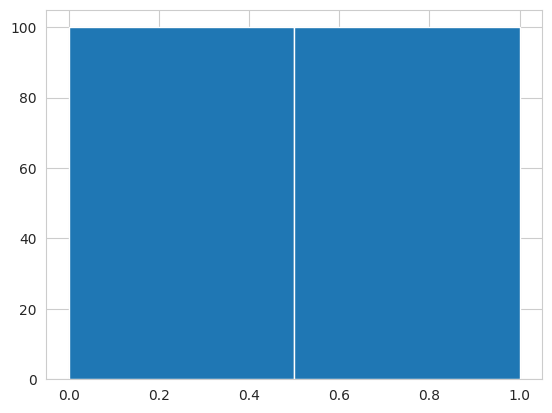

In [4]:
labels_df[' hemorrhage'].hist(bins=2)

There is the same amount of data for both cases.

Images are not the same sizes! We need to find the optimal size, but before we have to explore it.

In [5]:
images_df = pd.DataFrame(images, columns=['image'])

In [6]:
images_df['width'] = images_df['image'].apply(lambda x: x.shape[0])
images_df['height'] = images_df['image'].apply(lambda x: x.shape[1])

array([[<AxesSubplot:title={'center':'height'}>,
        <AxesSubplot:title={'center':'width'}>]], dtype=object)

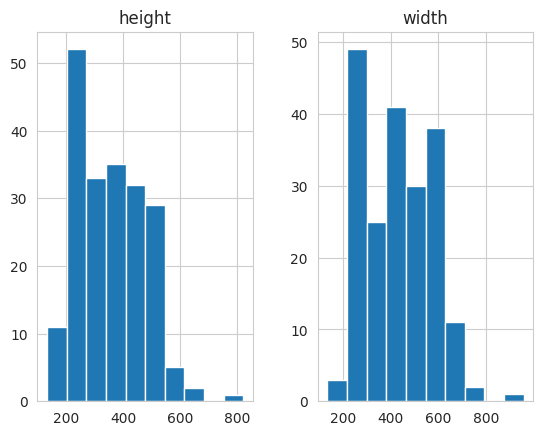

In [7]:
images_df[['height', 'width']].hist(bins=10)

In [9]:
images_df[['height', 'width']].describe()

,height,width
count,200.000000,200.000000
mean,355.505000,433.720000
std,116.785247,142.059481
min,134.000000,135.000000
25%,252.000000,298.750000
50%,345.000000,435.500000
75%,447.250000,554.000000
max,821.000000,957.000000


Before we will create and train model, we need to make all images the same sizes.

The tradeoff is simple here - lesser images would be faster to train, there would be a lot of examples so lesser chance of overfitting, but it is a clear loss of information. If the error would be still big, we will need to consider to use a bigger size, and either stretch little images (and lose quality significantly) or drop them entirely (and risk overfitting).

For now we will go the simplest path - resizing to the smallest size (and even smaller - 128 insted of 134).

In [10]:
images = np.array([cv2.resize(image, (128, 128)) for image in images])

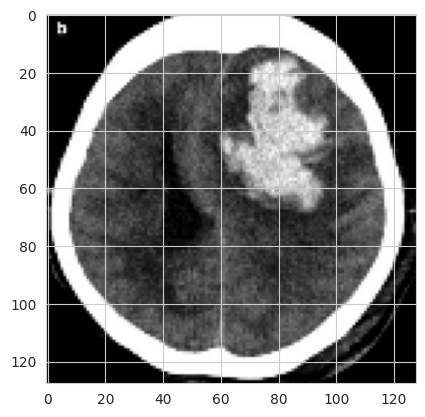

In [11]:
plt.imshow(images[0])

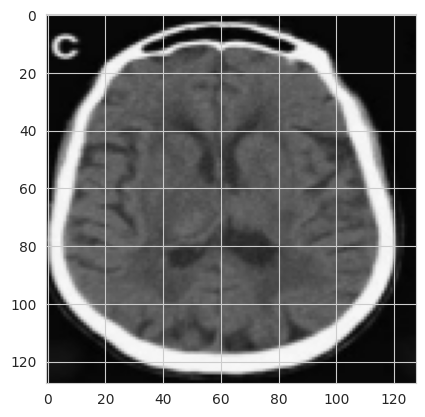

In [12]:
plt.imshow(images[100])

The quality of images seems to be acceptable.

# Adding flipped images

We could also improve the dataset by adding flipped images. It doesn't matter from what side we will look at the CT scan, brain hemorrhage can and should be diagnosed just as well. By adding flipped images to dataset, we can greatly increase the accuracy of model.

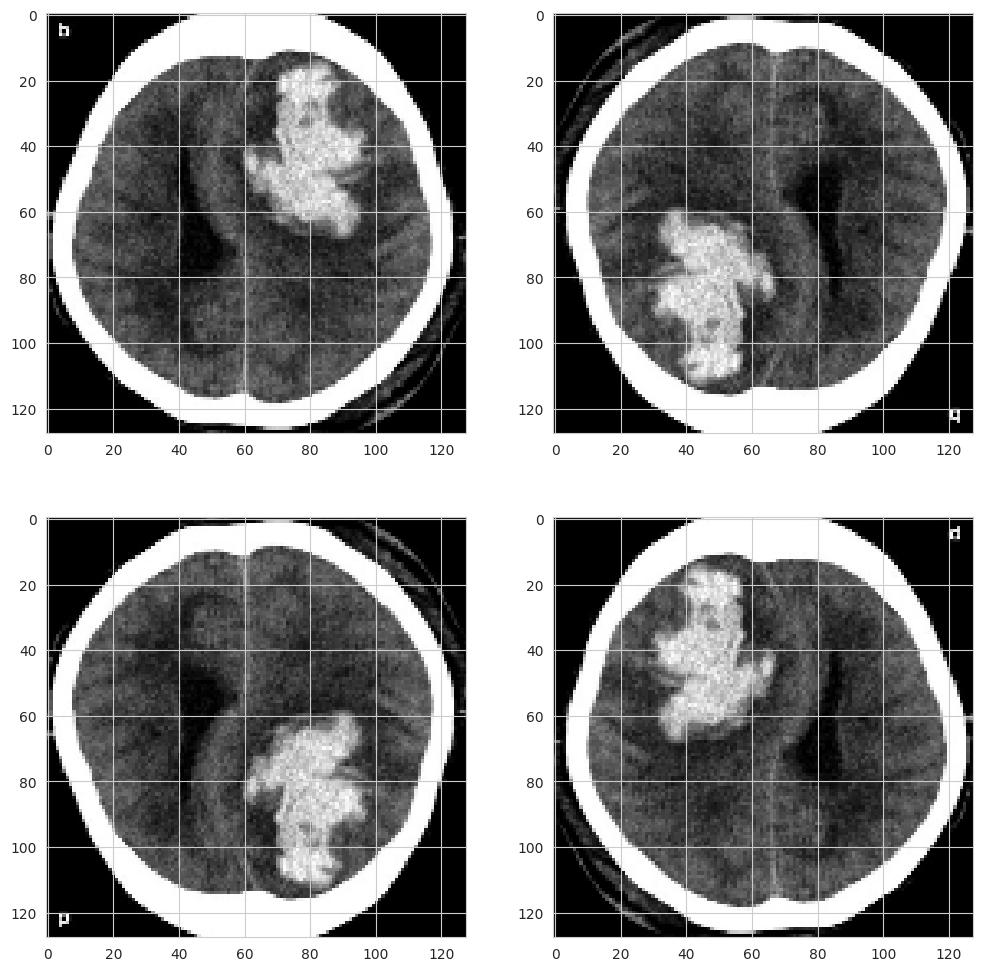

In [13]:
plt.figure(figsize=(12, 12))
for i, flip in enumerate([None, -1, 0, 1]):
    plt.subplot(221 + i)
    if flip is None:
        plt.imshow(images[0])
    else:
        plt.imshow(cv2.flip(images[0], flip))

Now, we don't want those flipped images in our test set just to be sure model didn't create any preferences for upside down and flipped images, so the dataset expansion should take place after split into train and test sets.

Fortunately, there is ImageDataGenerator for the purposes of flipping and rotating images.

Split data into train, validation and test subsets.

In [14]:
print(labels)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [15]:
# since data is strictly true until index 100 and then strictly false,
# we can take random 90 entries from frist half and then random 90 from the second half
# to have evenly distributed train and test sets
indicies = np.random.permutation(100)
train_true_idx, test_true_idx = indicies[:90], indicies[90:]
train_false_idx, test_false_idx = indicies[:90] + 100, indicies[90:] + 100
train_idx, test_idx = np.append(train_true_idx, train_false_idx), np.append(test_true_idx, test_false_idx)

train_validationX, train_validationY = images[train_idx], labels[train_idx]
testX, testY = images[test_idx], labels[test_idx]

print(train_validationX.shape, testX.shape)
print(train_validationY.shape, testY.shape)

(180, 128, 128, 3) (20, 128, 128, 3)
(180,) (20,)


In [16]:
# now to split train and validation sets
tr_len = train_validationX.shape[0]
train_val_split = int(tr_len*0.9)
indicies = np.random.permutation(tr_len)
train_idx, validation_idx = indicies[:train_val_split], indicies[train_val_split:]

trainX, trainY = train_validationX[train_idx], train_validationY[train_idx]
validationX, validationY = train_validationX[validation_idx], train_validationY[validation_idx]

print(trainX.shape, validationX.shape)
print(trainY.shape, validationY.shape)

(162, 128, 128, 3) (18, 128, 128, 3)
(162,) (18,)


>Now it's times to get our hand dirty where we import the needed libraries to train the model 

In [17]:
import keras

2023-05-22 09:55:39.681762: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 09:55:41.427081: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ubuntu/miniconda3/envs/env/lib/python3.7/site-packages/cv2/../../lib64::/usr/local/cuda-11.6/lib64:/usr/local/cuda-11.6/lib64
2023-05-22 09:55:41.427290: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Input, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

import math

# Image Segmentation & augmentation

In [19]:
train_image_data = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.,
    zoom_range=0.05,
    rotation_range=180,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0
)
validation_image_data = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.,
    zoom_range=0.05,
    rotation_range=90,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0)

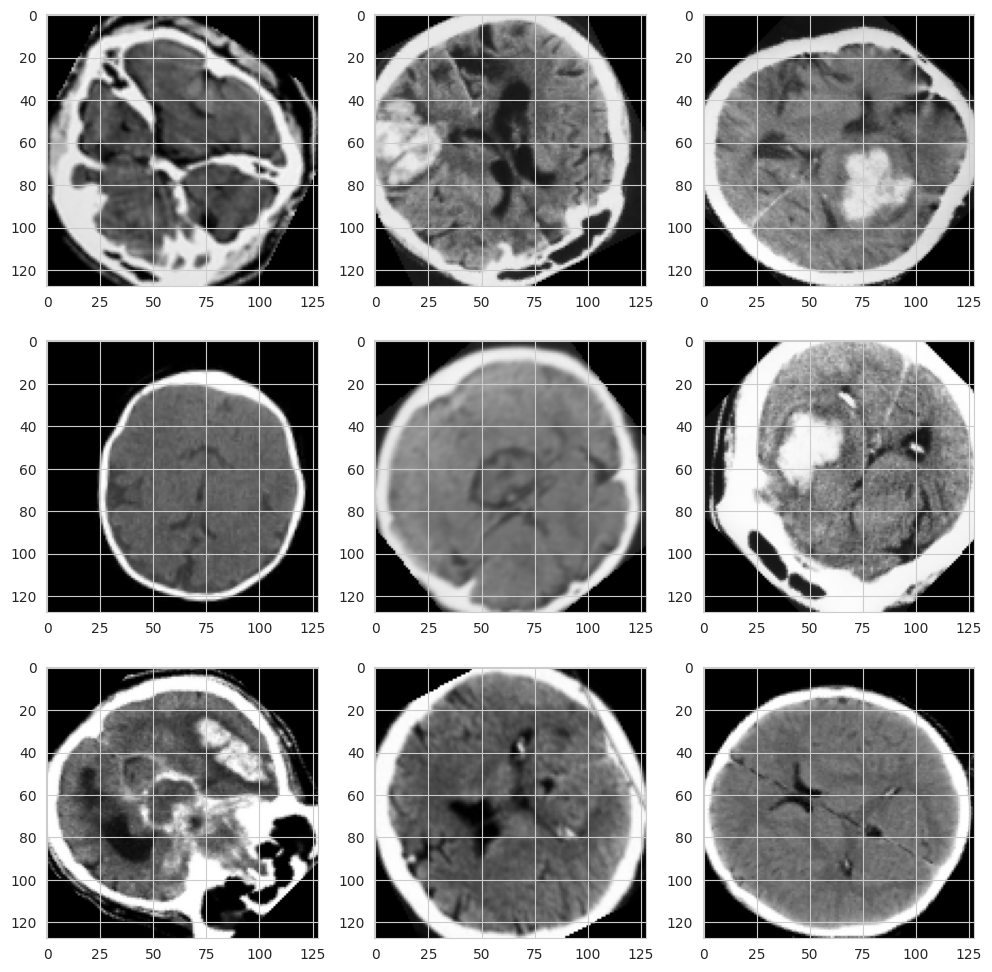

In [20]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_image_data.flow(trainX, trainY, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i])
    plt.show()
    break

# Building the model

In [21]:
def check_accuracy(model, setX, actual, print_images=True):
    predicted = np.array([int(x[0] > 0.5) for x in model.predict(setX)])
    if print_images:
        rows = math.ceil(len(predicted)/10.)
        plt.figure(figsize=(20, 3 * rows))
        for i in range(len(predicted)):
            plt.subplot(rows, 10, i+1)
            plt.imshow(setX[i])
            plt.title("pred "+str(predicted[i])+" actual "+str(actual[i]))
        
    confusion = confusion_matrix(actual, predicted)
    tn, fp, fn, tp = confusion.ravel()
    print("True positive:", tp, ", True negative:", tn,
          ", False positive:", fp, ", False negative:", fn)

    print("Total accuracy:", np.sum(predicted==actual) / len(predicted) * 100., "%")
    return (tn, fp, fn, tp)

In [22]:
def simple_conv_model(input_shape):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.4))
    
    model.add(Dense(1, activation='sigmoid'))
    return model

In [23]:
model = simple_conv_model((128, 128, 3))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

2023-05-22 09:55:54.711649: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-22 09:55:54.787528: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-22 09:55:54.787727: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-22 09:55:54.788428: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 global_average_pooling2d (G  (None, 64)               0

# Training model

In [78]:
model.fit(train_image_data.flow(trainX, trainY, batch_size=45),
    steps_per_epoch=4,
    validation_data=validation_image_data.flow(validationX, validationY, batch_size=2),
    validation_steps=9,
    callbacks=[ModelCheckpoint("weights.h5", monitor='val_acc', save_best_only=True, mode='max')],
    epochs=4)

Epoch 1/4
40/40 [==============================] - 0s 10ms/step - loss: 0.3309 - accuracy: 0.8765 - val_loss: 0.1893 - val_accuracy: 0.9444


1/1 [==============================] - 0s 24ms/step
True positive: 10 , True negative: 5 , False positive: 3 , False negative: 0
Total accuracy: 83.33333333333334 %


(5, 3, 0, 10)

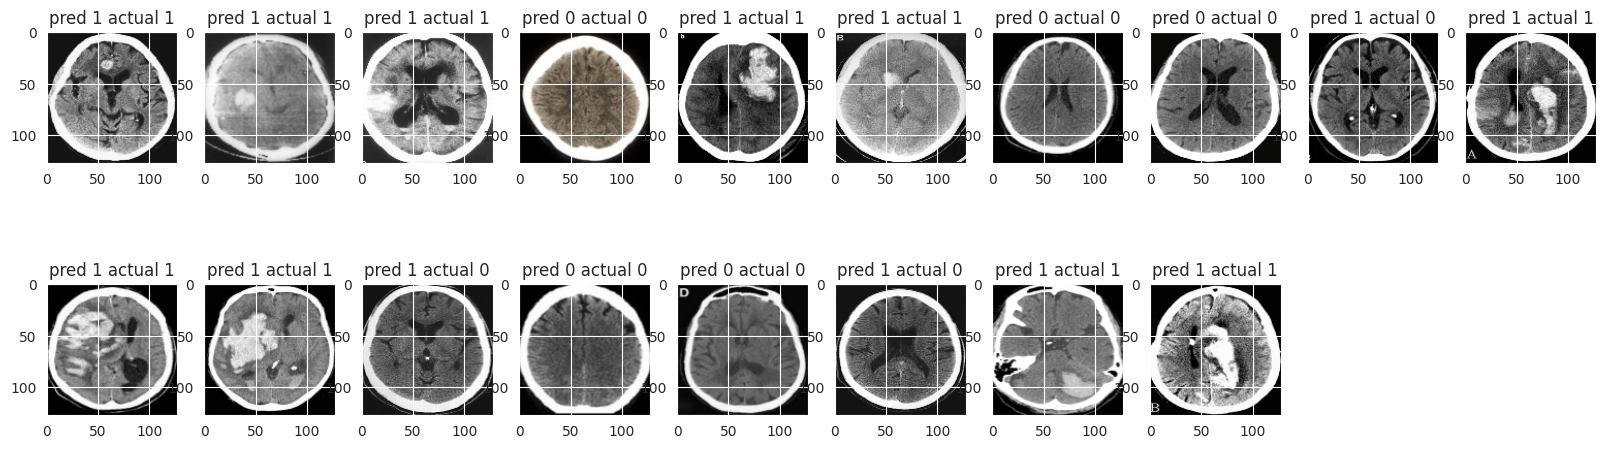

In [48]:
check_accuracy(model, validationX/255., validationY)

In [25]:
model.save("last-weights.h5")
model.load_weights("weights.h5")

In [26]:
check_accuracy(model, trainX/255., trainY, False)

True positive: 83 , True negative: 56 , False positive: 22 , False negative: 1
Total accuracy: 85.80246913580247 %


(56, 22, 1, 83)

True positive: 6 , True negative: 9 , False positive: 3 , False negative: 0
Total accuracy: 83.33333333333334 %


(9, 3, 0, 6)

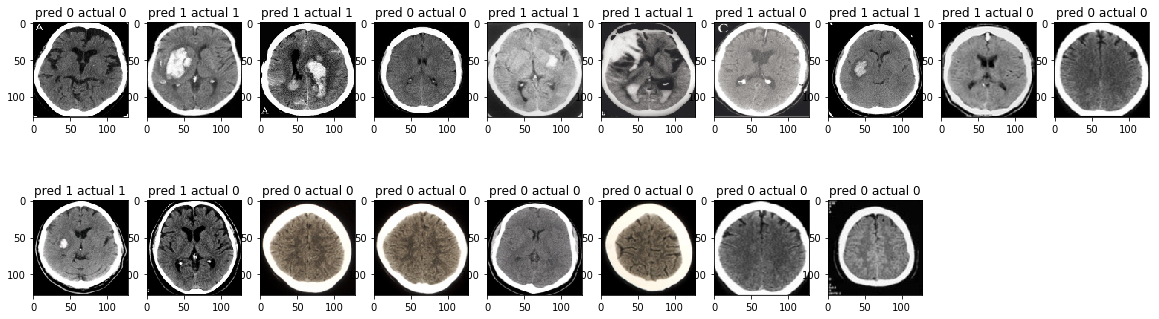

In [27]:
check_accuracy(model, validationX/255., validationY)

The overall generalization of model seems good, overfitting isn't too big. But since this is a medical problem, we have to consider one additional thing.

# False negative result will kill patient
False positive result will be an inconvinience.

We have to punish false negative results while training the model.

Punishing false negatives may be implemented in several ways.
* imbalance dataset so there are more positive cases, therefore model will prefer false positives over false negatives
* make it a multiclass classification and use 'class_weight' parameter of Keras (which is essentially will do the same trick)
* write custom loss function that is oriented on lowering false negativer rate (or improving _sensitivity_)
* or write custom metrics, based on which checkpoint will save model

Let's try the approach with imbalancing training dataset.

In [28]:
def imbalance_set(coeff=2):
    imbalanced_trainX = []
    imbalanced_trainY = []
    for i, train_x in enumerate(trainX):
        def add_entry(x, y):
            imbalanced_trainX.append(x)
            imbalanced_trainY.append(y)

        add_entry(train_x, trainY[i])

        if(trainY[i] == 1):
            for j in range(coeff-1):
                add_entry(train_x, trainY[i])
    return (np.array(imbalanced_trainX), np.array(imbalanced_trainY))

imbalanced_trainX, imbalanced_trainY = imbalance_set(2)
print(imbalanced_trainX.shape, imbalanced_trainY.shape)

(246, 128, 128, 3) (246,)


In [29]:
def bigger_conv_model(input_shape):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    
    model.add(Dense(1, activation='sigmoid'))
    return model

In [30]:
model = bigger_conv_model((128, 128, 3))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
global_average_pooling2d_2 ( (None, 64)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
__________

In [32]:
model.fit_generator(train_image_data.flow(imbalanced_trainX, imbalanced_trainY, batch_size=128),
    steps_per_epoch=128,
    validation_data=validation_image_data.flow(validationX, validationY, batch_size=16),
    validation_steps=100,
    callbacks=[ModelCheckpoint("bigger_model_checkpoint_weights.h5", monitor='val_acc', save_best_only=True, mode='max')],
    epochs=24)

NameError: name 'imbalanced_trainX' is not defined

In [32]:
check_accuracy(model, trainX/255., trainY, False)

True positive: 84 , True negative: 71 , False positive: 7 , False negative: 0
Total accuracy: 95.67901234567901 %


(71, 7, 0, 84)

In [33]:
check_accuracy(model, validationX/255., validationY, False)

True positive: 6 , True negative: 11 , False positive: 1 , False negative: 0
Total accuracy: 94.44444444444444 %


(11, 1, 0, 6)

In [34]:
model.save("bigger_model_latest_weights.h5")
model.load_weights("bigger_model_checkpoint_weights.h5")

In [35]:
check_accuracy(model, trainX/255., trainY, False)

True positive: 84 , True negative: 64 , False positive: 14 , False negative: 0
Total accuracy: 91.35802469135803 %


(64, 14, 0, 84)

In [36]:
check_accuracy(model, validationX/255., validationY, False)

True positive: 6 , True negative: 10 , False positive: 2 , False negative: 0
Total accuracy: 88.88888888888889 %


(10, 2, 0, 6)

# 89% of accuracy on validation set and 0 false negative
Time to check model on test set

True positive: 9 , True negative: 7 , False positive: 3 , False negative: 1
Total accuracy: 80.0 %


(7, 3, 1, 9)

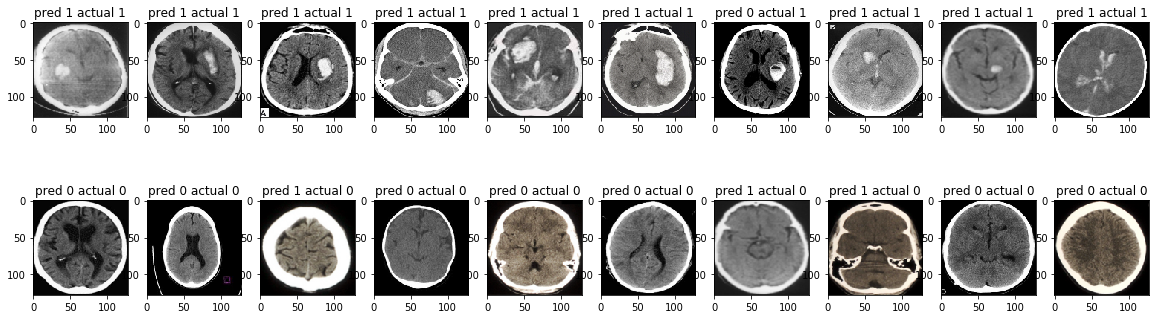

In [37]:
check_accuracy(model, testX/255., testY)

Model showed good results.

Additional improvements could be made if image augmentation contained alterations of contrast.

In [64]:
for i,e in train_image_data.flow(trainX, trainY, batch_size=170):
    print(i.shape, e.shape)

(162, 128, 128, 3) (162,)
(162, 128, 128, 3) (162,)
(162, 128, 128, 3) (162,)
(162, 128, 128, 3) (162,)
(162, 128, 128, 3) (162,)
(162, 128, 128, 3) (162,)
(162, 128, 128, 3) (162,)
(162, 128, 128, 3) (162,)
(162, 128, 128, 3) (162,)


KeyboardInterrupt: 